# Dataset CustomerSupportTraining

In [3]:
import pandas as pd

data = pd.read_csv('CustomerSupportTraining.csv')
data.head()


,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


# Show the report classification


=== Classification Report ===
                          precision    recall  f1-score   support

            cancel_order       1.00      1.00      1.00       998
            change_order       1.00      1.00      1.00       997
 change_shipping_address       1.00      1.00      1.00       973
  check_cancellation_fee       1.00      1.00      1.00       950
           check_invoice       1.00      1.00      1.00      1000
   check_payment_methods       1.00      1.00      1.00       999
     check_refund_policy       1.00      1.00      1.00       997
               complaint       1.00      1.00      1.00      1000
contact_customer_service       1.00      1.00      1.00      1000
     contact_human_agent       1.00      1.00      1.00       999
          create_account       1.00      1.00      1.00       997
          delete_account       1.00      1.00      1.00       995
        delivery_options       1.00      1.00      1.00       995
         delivery_period       1.00      1.0

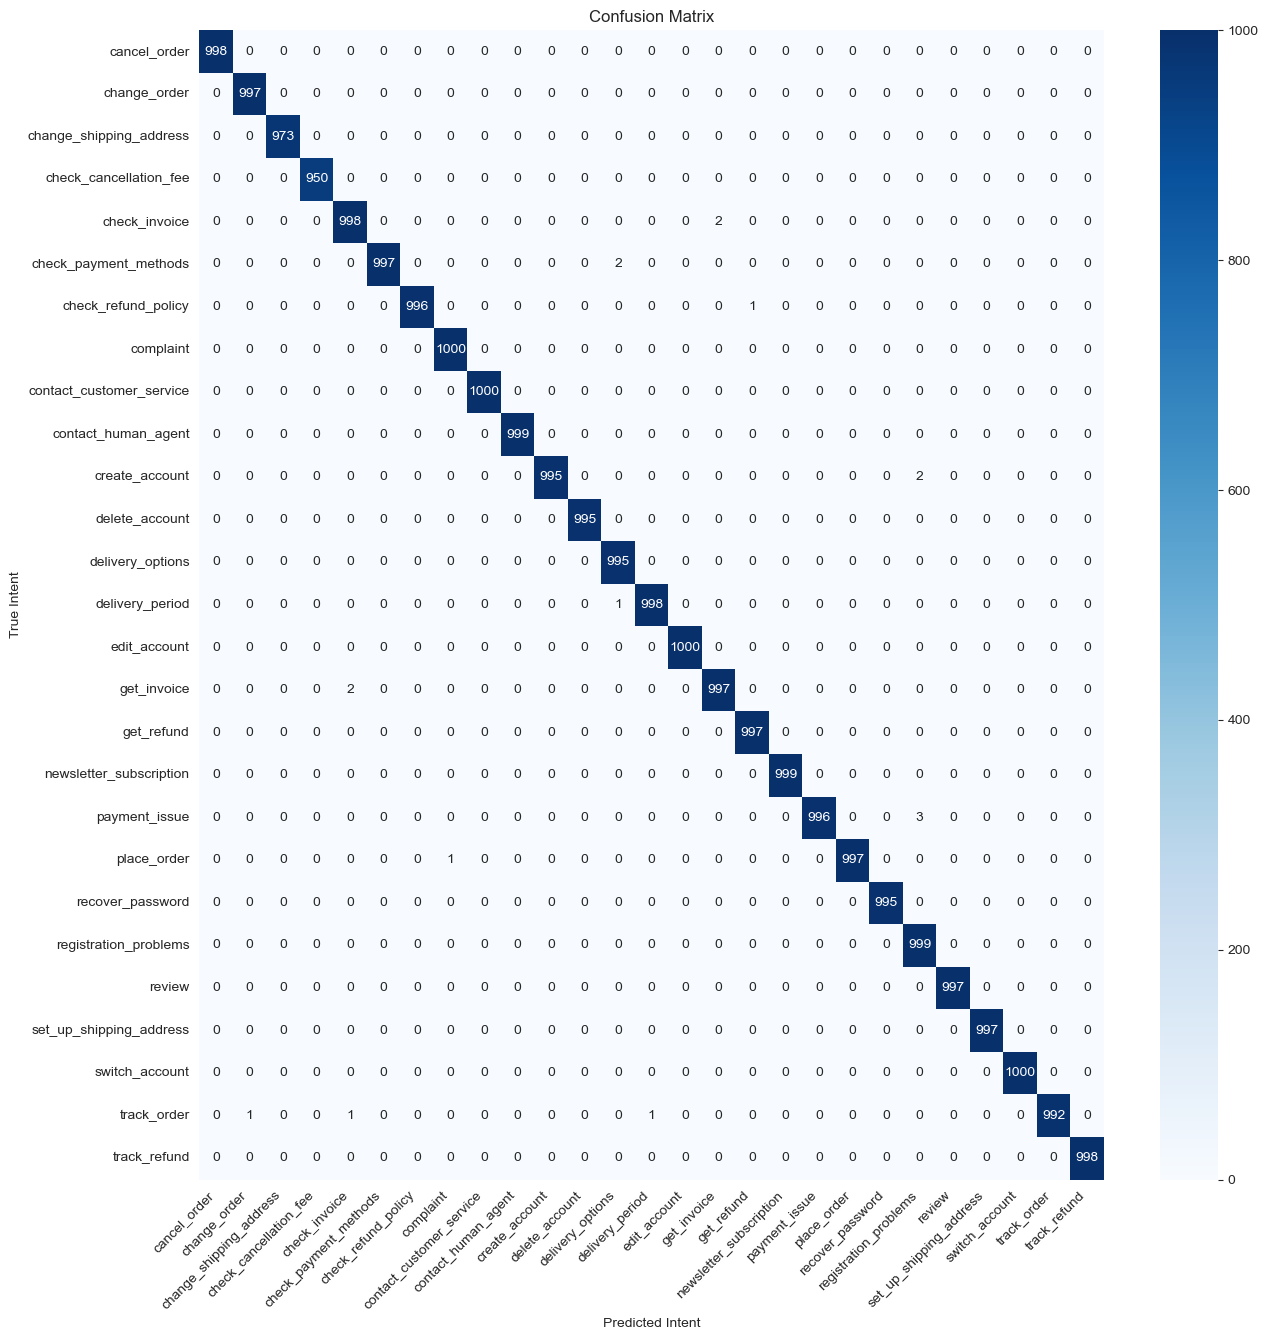


=== Response Quality ===
ROUGE-1 F1 (avg): 0.9997
ROUGE-L F1 (avg): 0.9995
BLEU (avg):       0.9994


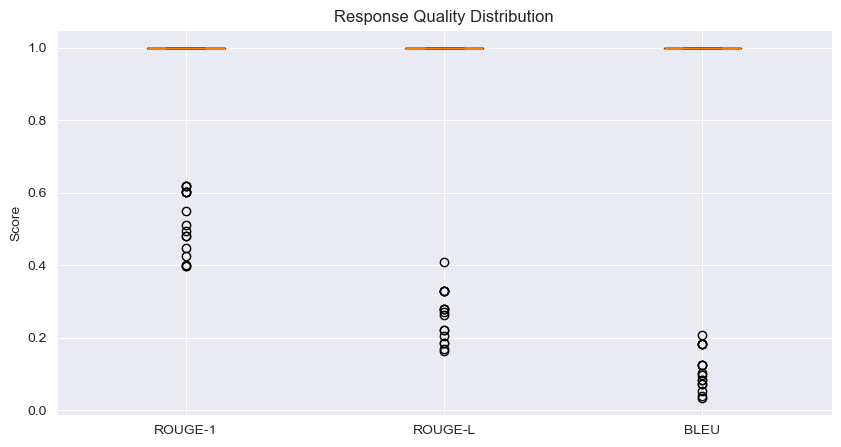


Input: I want to cancel order 1234
Predictions: [{'intent': 'cancel_order', 'score': 0.9999643564224243, 'response': "I truly understand that you're experiencing difficulties in canceling your purchase with the order number {{Order Number}}. I apologize for any inconvenience this has caused you. Our team is committed to resolving this issue and assisting you in the best possible way.\n\nTo address the problems you're facing, I suggest the following steps:\n\n1. Double-Check the Order Details: Make sure that the order number you entered is correct and matches the purchase you want to cancel. It's possible to mistakenly input the wrong number, so let's verify the details.\n\n2. Customer Support Assistance: Reach out to our dedicated customer support team for immediate assistance. They have the expertise and resources to help you troubleshoot and resolve any issues you're facing with canceling your purchase. You can contact them during {{Customer Support Hours}} at {{Customer Support Pho

In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Config ----------
MODEL_DIR = "./intent_results/model"
CSV_PATH = "CustomerSupportTraining.csv"
TEXT_COLUMN = "instruction"
LABEL_COLUMN = "intent"
MAX_LENGTH = 128

# ---------- NLTK setup ----------
try:
    _ = nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

# ---------- Load model & tokenizer ----------
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_DIR)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with open(os.path.join(MODEL_DIR, "label_map.json"), "r", encoding="utf-8") as f:
    maps = json.load(f)
id2label = {int(k): v for k, v in maps["id2label"].items()}
label2id = maps["label2id"]

with open(os.path.join(MODEL_DIR, "intent_to_response.json"), "r", encoding="utf-8") as f:
    intent_to_response = json.load(f)

# ---------- Load dataset ----------
df = pd.read_csv(CSV_PATH, sep=None, engine="python")
df = df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN]).reset_index(drop=True)
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype("category")
labels = list(df[LABEL_COLUMN].cat.categories)

X_test = df[TEXT_COLUMN].astype(str).tolist()
y_test = df[LABEL_COLUMN].cat.codes.values

# ---------- Prediction function ----------
def predict(texts, batch_size=16):  # you can adjust batch_size
    preds = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            outputs = model(**enc)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
        preds.extend(np.argmax(probs, axis=1))
    return np.array(preds)


y_pred = predict(X_test)

# ---------- Precision, Recall, F1 ----------
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=labels, zero_division=0))

# ---------- Confusion Matrix Plot ----------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(max(8, len(labels) * 0.5), max(6, len(labels) * 0.5)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Intent")
plt.ylabel("True Intent")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ---------- ROUGE & BLEU ----------
scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)
smooth = SmoothingFunction().method4

rouge1_f, rougel_f, bleu_scores = [], [], []

for i in range(len(y_test)):
    gold_intent = id2label[y_test[i]]
    pred_intent = id2label[y_pred[i]]

    gold_resp = intent_to_response.get(gold_intent, "")
    pred_resp = intent_to_response.get(pred_intent, "")

    # ROUGE
    r = scorer.score(gold_resp, pred_resp)
    rouge1_f.append(r["rouge1"].fmeasure)
    rougel_f.append(r["rougeL"].fmeasure)

    # BLEU
    ref_tokens = [gold_resp.split()]
    cand_tokens = pred_resp.split()
    bleu = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smooth) if cand_tokens else 0.0
    bleu_scores.append(bleu)

print("\n=== Response Quality ===")
print(f"ROUGE-1 F1 (avg): {np.mean(rouge1_f):.4f}")
print(f"ROUGE-L F1 (avg): {np.mean(rougel_f):.4f}")
print(f"BLEU (avg):       {np.mean(bleu_scores):.4f}")

# ---------- ROUGE & BLEU Boxplot ----------
plt.figure(figsize=(10, 5))
plt.boxplot([rouge1_f, rougel_f, bleu_scores], tick_labels=["ROUGE-1", "ROUGE-L", "BLEU"])
plt.title("Response Quality Distribution")
plt.ylabel("Score")
plt.show()

# ---------- Optional: Demo predictions ----------
sample_texts = [
    "I want to cancel order 1234",
    "How do I return a product?",
    "Can I get a refund for my purchase?"
]

for t in sample_texts:
    enc = tokenizer(t, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        outputs = model(**enc)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    top_idx = probs.argsort()[::-1][:3]
    results = [{"intent": id2label[idx], "score": float(probs[idx]), "response": intent_to_response.get(id2label[idx], "" )} for idx in top_idx]
    print(f"\nInput: {t}")
    print("Predictions:", results)


# Bart Model Fast Download
- **Already Download, not need download again, wasted time**

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
import transformers
import torch
print("Transformers version:", transformers.__version__)

# -----------------------------
# Check device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Step 1. Load dataset
# -----------------------------
data = pd.read_csv("CustomerSupportTraining.csv")  # <-- replace with your CSV
inputs = data["instruction"].tolist()
targets = data["response"].tolist()

dataset = Dataset.from_dict({"input_text": inputs, "target_text": targets})
dataset = dataset.train_test_split(test_size=0.2)

# -----------------------------
# Step 2. Tokenizer (smaller model: DistilBART)
# -----------------------------
tokenizer = BartTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
model = BartForConditionalGeneration.from_pretrained("sshleifer/distilbart-cnn-12-6")

# Move model to device
model.to(device)

def preprocess(batch):
    model_inputs = tokenizer(
        batch["input_text"], max_length=64, truncation=True, padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["target_text"], max_length=64, truncation=True, padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["input_text", "target_text"])

# -----------------------------
# Step 3. Use small subset (for faster training)
# -----------------------------
train_small = tokenized_dataset["train"].shuffle(seed=42).select(range(500))
eval_small = tokenized_dataset["test"].shuffle(seed=42).select(range(100))

# -----------------------------
# Step 4. Training
# -----------------------------
training_args = TrainingArguments(
    output_dir="./bart_results_fast",
    do_eval=True,
    eval_steps=100,             # evaluate every 100 steps
    save_steps=100,             # save checkpoint every 100 steps
    logging_steps=50,           # log metrics every 50 steps
    learning_rate=5e-5,
    per_device_train_batch_size=8,   # bigger batch if GPU available
    per_device_eval_batch_size=8,
    num_train_epochs=1,         # only 1 epoch (fast)
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
    fp16=True,                  # use mixed precision (if GPU available)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_small,
    eval_dataset=eval_small,
    tokenizer=tokenizer,
)

trainer.train()

# -----------------------------
# Step 5. Save fine-tuned model
# -----------------------------
model.save_pretrained("./bart_model_fast")
tokenizer.save_pretrained("./bart_model_fast")

print("✅ Fast DistilBART model saved in ./bart_model_fast/")


# Training model and Evaluate Algorithms

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
from dataclasses import dataclass
from typing import Dict, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

import matplotlib.pyplot as plt

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer, TrainingArguments
)

from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import transformers
print(transformers.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Config ----------
CSV_PATH = "CustomerSupportTraining.csv"
TEXT_COLUMN = "instruction"
LABEL_COLUMN = "intent"
RESPONSE_COLUMN = "response"
MAX_LENGTH = 128
OUTPUT_DIR = "./intent_results"
MODEL_DIR = os.path.join(OUTPUT_DIR, "model")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Make sure NLTK has what it needs
try:
    _ = nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

# ---------- 1) Load data ----------
# Auto-detect separator (comma/tab/semicolon)
df = pd.read_csv(CSV_PATH, sep=None, engine="python")
# Keep only needed columns
needed_cols = [TEXT_COLUMN, LABEL_COLUMN, RESPONSE_COLUMN]
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns in CSV: {missing}")

# Drop rows with empty fields
df = df.dropna(subset=needed_cols).reset_index(drop=True)

# Map label↔id
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype("category")
labels = list(df[LABEL_COLUMN].cat.categories)
label2id: Dict[str, int] = {l: i for i, l in enumerate(labels)}
id2label: Dict[int, str] = {i: l for l, i in label2id.items()}

# Build a dictionary to get a canonical response by intent
# If multiple rows share the same intent, we keep the first response.
intent_to_response: Dict[str, str] = {}
for intent, group in df.groupby(LABEL_COLUMN, sort=False):
    # prefer the longest response (often better reference), else first
    best_row = group.loc[group[RESPONSE_COLUMN].str.len().idxmax()]
    intent_to_response[intent] = best_row[RESPONSE_COLUMN]

print(f"Found {len(labels)} intents.")
print("Label mapping:", label2id)

# ---------- 2) Train/val split ----------
X_train, X_test, y_train, y_test = train_test_split(
    df[TEXT_COLUMN].astype(str).tolist(),
    df[LABEL_COLUMN].cat.codes.values,
    test_size=0.2,
    random_state=42,
    stratify=df[LABEL_COLUMN].cat.codes.values
)

# ---------- 3) Tokenize ----------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_enc = tokenizer(X_train, truncation=True, padding=True, max_length=MAX_LENGTH)
test_enc = tokenizer(X_test, truncation=True, padding=True, max_length=MAX_LENGTH)

class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[i])
        return item

train_ds = IntentDataset(train_enc, y_train)
test_ds  = IntentDataset(test_enc, y_test)

# ---------- 4) Model ----------
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# ---------- 5) Train ----------
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

def compute_metrics(eval_pred):
    logits, labels_np = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels_np, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(labels_np, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# ---------- 6) Evaluate ----------
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=labels, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(max(6, len(labels) * 0.8), max(5, len(labels) * 0.8)))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha="right")
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"), dpi=160)
plt.close()
print(f"Saved confusion matrix → {os.path.join(OUTPUT_DIR, 'confusion_matrix.png')}")

# ---------- 7) ROUGE & BLEU for responses ----------
scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)
smooth = SmoothingFunction().method4

rouge1_f, rougel_f, bleu_scores = [], [], []

# For each test item, compare the canonical response of:
#  - gold intent vs predicted intent
# (This checks whether the predicted intent would lead to a response similar to the gold response.)
y_test_list = list(y_test)
for i in range(len(y_test_list)):
    gold_intent = id2label[y_test_list[i]]
    pred_intent = id2label[y_pred[i]]

    gold_resp = intent_to_response.get(gold_intent, "")
    pred_resp = intent_to_response.get(pred_intent, "")

    # ROUGE
    r = scorer.score(gold_resp, pred_resp)
    rouge1_f.append(r["rouge1"].fmeasure)
    rougel_f.append(r["rougeL"].fmeasure)

    # BLEU (sentence-level, tokenized simply on whitespace)
    ref_tokens = [gold_resp.split()]
    cand_tokens = pred_resp.split()
    bleu = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smooth) if cand_tokens else 0.0
    bleu_scores.append(bleu)

print("\n=== Response Quality (Predicted vs Gold Response) ===")
print(f"ROUGE-1 F1 (avg): {np.mean(rouge1_f):.4f}")
print(f"ROUGE-L F1 (avg): {np.mean(rougel_f):.4f}")
print(f"BLEU (avg):       {np.mean(bleu_scores):.4f}")

# ---------- 8) Save artifacts ----------
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
with open(os.path.join(MODEL_DIR, "label_map.json"), "w", encoding="utf-8") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2, ensure_ascii=False)

with open(os.path.join(MODEL_DIR, "intent_to_response.json"), "w", encoding="utf-8") as f:
    json.dump(intent_to_response, f, indent=2, ensure_ascii=False)

print(f"\nSaved model & tokenizer → {MODEL_DIR}")
print("Saved label map and intent_to_response lookup as JSON.")

# ---------- 9) Simple predictor ----------
def predict(text: str, top_k: int = 1):
    enc = tokenizer(text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**enc)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    top_idx = probs.argsort()[::-1][:top_k]
    results = []
    for idx in top_idx:
        intent = id2label[idx]
        results.append({
            "intent": intent,
            "score": float(probs[idx]),
            "response": intent_to_response.get(intent, "")
        })
    return results

# Demo
sample_texts = [
    "i have a question about cancelling order 12345",
    "I need to cancel purchase 999",
]
for t in sample_texts:
    print("\nInput:", t)
    print("Prediction:", predict(t, top_k=3))


# Chatbot App ML UI output

In [2]:
import os
import re
import torch
import pandas as pd
import tkinter as tk
from tkinter import scrolledtext, Frame, Label, Entry, Button
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    BartTokenizer,
    BartForConditionalGeneration
)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import json
import random
from rapidfuzz import fuzz, process
from datetime import datetime
# -------------------------------
# Paths to models and CSV
# -------------------------------
INTENT_MODEL_PATH = "./intent_results/model"  # DistilBERT intent model
BART_MODEL_PATH = "./bart_model_fast"         # BART fine-tuned model
CSV_PATH = "CustomerSupportTraining.csv"      # Must contain 'instruction', 'response', 'intent'

# -------------------------------
# Load CSV and build intent->response dict
# -------------------------------
data = pd.read_csv(CSV_PATH)
intent_to_response = {}
for intent, group in data.groupby("intent"):
    responses = group["response"].dropna()
    responses = responses[responses.str.strip() != ""]  # remove empty strings
    if len(responses) == 0:
        continue
    longest_idx = responses.str.len().idxmax()
    intent_to_response[intent] = responses.loc[longest_idx]

# -------------------------------
# Load DistilBERT for intent classification
# -------------------------------
intent_tokenizer = DistilBertTokenizerFast.from_pretrained(INTENT_MODEL_PATH)
intent_model = DistilBertForSequenceClassification.from_pretrained(INTENT_MODEL_PATH)
intent_model.eval()

# -------------------------------
# Load BART for response generation
# -------------------------------
bart_tokenizer = BartTokenizer.from_pretrained(BART_MODEL_PATH)
bart_model = BartForConditionalGeneration.from_pretrained(BART_MODEL_PATH)
bart_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
intent_model.to(device)
bart_model.to(device)

# -------------------------------
# Predict intent
# -------------------------------


def predict_intent(text, threshold=0.7):
    enc = intent_tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        outputs = intent_model(**enc)
        probs = torch.softmax(outputs.logits, dim=-1)[0].cpu().numpy()

    idx = probs.argmax()
    confidence = float(probs[idx])
    intent = intent_model.config.id2label[idx]

    # Reject low-confidence predictions
    if confidence < threshold:
        return None, confidence
    return intent, confidence



# -------------------------------
# Evaluate BLEU
# -------------------------------
def evaluate_response(user_input, candidate):
    intent, _ = predict_intent(user_input)
    reference_text = intent_to_response.get(intent, "")
    if not reference_text:
        return 0.0
    smoothie = SmoothingFunction().method4
    reference_tokens = [reference_text.split()]
    candidate_tokens = candidate.split()
    return sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothie)


def get_response_template(intent):
    # Prefer JSON if available
    intent_info = intents_data["intents"].get(intent, {})
    responses = intent_info.get("responses", [])
    if responses:
        return random.choice(responses)

    # Fallback to CSV
    if intent in intent_to_response:
        return intent_to_response[intent]

    return None


import json
# Load intents + placeholders JSON
with open("intents.json", "r", encoding="utf-8") as f:
    intents_data = json.load(f)

import re, random

# --- Normalize odd placeholder casing in CSV responses, e.g. {{oRDER NUMBER}} -> {{Order Number}}
PLACEHOLDER_ALIASES = {
    "order number": "Order Number",
    "tracking number": "Tracking Number",
    "invoice number": "Invoice Number",
    "person name": "Person Name",
    "online company portal info": "Online Company Portal Info",
    "online order interaction": "Online Order Interaction",
    "customer support hours": "Customer Support Hours",
    "customer support phone number": "Customer Support Phone Number",
    "website url": "Website URL",
    "company name": "Company Name",
    "account type": "Account Type",
    "account category": "Account Category",
    "money amount": "Money Amount",
    "refund amount": "Refund Amount",   # ✅ NEW
    "contact method": "Contact Method"
}


def normalize_placeholders(text: str) -> str:
    def repl(m):
        inner = m.group(1).strip()
        canon = PLACEHOLDER_ALIASES.get(inner.casefold(), inner)
        return "{{" + canon + "}}"
    # Replace ANY {{ ... }} case-insensitively to canonical names if known
    return re.sub(r"\{\{\s*([^}]+?)\s*\}\}", repl, text)

# Apply normalization to CSV columns we will use
data["response"] = data["response"].astype(str).apply(normalize_placeholders)
data["instruction"] = data["instruction"].astype(str)

# Keep groups for runtime selection and a fallback "longest" dict
intent_groups = {i: g.reset_index(drop=True) for i, g in data.groupby("intent")}
intent_to_response = {}
for intent, group in intent_groups.items():
    resp_series = group["response"].astype(str)
    longest_idx = resp_series.str.len().idxmax()
    intent_to_response[intent] = resp_series.loc[longest_idx]


def fill_placeholders(response_template: str, user_input: str, intent: str) -> str:
    if not response_template:
        return ""

    response_template = normalize_placeholders(response_template)

    # --- Extract values from intent-specific rules in JSON
    intent_info = intents_data["intents"].get(intent, {})
    intent_placeholder_rules = intent_info.get("placeholders", {})

    for name, pattern in intent_placeholder_rules.items():
        match = re.search(pattern, user_input, flags=re.IGNORECASE)
        if match:
            value = match.group(0)
            response_template = re.sub(
                r"\{\{\s*" + re.escape(name) + r"\s*\}\}",
                value,
                response_template,
                flags=re.IGNORECASE
            )

    # --- Global placeholders (with dynamic detection)
    global_ph = intents_data.get("placeholders", {})
    for placeholder, options in global_ph.items():
        if placeholder not in response_template:
            continue

        replacement = None

        if options and options[0] != "<dynamic>":
            # Predefined replacements
            replacement = random.choice(options)
        else:
            # Handle dynamic placeholders by regex
            if placeholder == "{{Order Number}}":
                match = re.search(r"\b\d{3,}\b", user_input)
            elif placeholder == "{{Tracking Number}}":
                match = re.search(r"\b[A-Z0-9]{8,}\b", user_input)
            elif placeholder == "{{Invoice Number}}":
                match = re.search(r"\b\d{5,}\b", user_input)
            elif placeholder in ["{{Refund Amount}}", "{{Money Amount}}"]:
                match = re.search(r"(RM\s?\d+(?:\.\d{1,2})?|\d+(?:\.\d{1,2})?\s?(?:USD|MYR|dollars))", user_input, re.IGNORECASE)
            elif placeholder == "{{Account Type}}":
                match = re.search(r"\b(saving|current|premium)\b", user_input, re.IGNORECASE)
            elif placeholder == "{{Account Category}}":
                match = re.search(r"\b(personal|business|corporate)\b", user_input, re.IGNORECASE)
            elif placeholder == "{{Person Name}}":
                # Match names: one or more capitalized words (e.g., John, John Doe, Mary Ann Lee)
                match = re.search(r"\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\b", user_input)
            elif placeholder == "{{Client Last Name}}":
                # Find all capitalized words and take the last one
                matches = re.findall(r"\b[A-Z][a-z]+\b", user_input)
                match = matches[-1] if matches else None
            else:
                match = None

            if isinstance(match, str):
                replacement = match
            elif match:
                replacement = match.group(0)
            else:
                replacement = "<dynamic>"


        response_template = response_template.replace(placeholder, replacement)

    return response_template




from rapidfuzz import fuzz, process
import random
# -------------------------------
# Generate best BART response
# -------------------------------

def normalize_instruction(text: str) -> str:
    # Replace any {{...}} placeholder with a neutral token
    return re.sub(r"\{\{[^}]+?\}\}", "__PH__", text)


def choose_best_response_for_intent(intent: str, user_input: str) -> str | None:
    group = intent_groups.get(intent)
    if group is None or group.empty:
        return None

    # Normalize user input (replace numbers with __PH__)
    user_norm = re.sub(r"\b\d{3,}\b", "__PH__", user_input)

    best_score = -1
    best_row_idx = None
    for i, inst in enumerate(group["instruction"].fillna("").astype(str)):
        inst_norm = normalize_instruction(inst)
        score = fuzz.token_set_ratio(user_norm, inst_norm)
        if score > best_score:
            best_score = score
            best_row_idx = i

    if best_row_idx is not None and best_score >= 65:  # lowered threshold
        return group.loc[best_row_idx, "response"]

    return intent_to_response.get(intent)



greeting_responses = [
    "Hello! How can I help you today?",
    "Hi there 👋, what can I do for you?",
    "Hey! Need any assistance?",
    "Welcome back! How may I assist you?",
    "Good to see you! How can I support you today?",
    "Hi 👋, what brings you here today?",
    "Hello! Need help with something?",
    "Hey there! How can I make your day easier?",
    "Hi, I’m here to help! What do you need?",
    "Welcome! How can I assist you right now?",
    "Hi there, looking for some support?",
    "Hello! What can I do for you today?"
]

exit_responses = [
        "👋 Thanks for chatting with me! Have a great day.",
        "See you soon! Take care 🙌",
        "Goodbye! Wishing you a wonderful day ahead 🌟",
        "Bye for now! Feel free to reach out anytime 💬",
        "Take care! I’ll be here if you need more help 😊",
        "👋 Have a great one! Looking forward to chatting again.",
        "Goodbye! Stay safe and well 🌿",
        "Catch you later! 👋",
        "It was nice talking with you. Have a great day 🌞",
        "Thanks for your time! Goodbye 🙏"
]

def get_bot_response(user_input: str) -> str:
    user_input_lower = user_input.lower().strip()

    # Greetings fast-path
    if any(g in user_input_lower for g in [
        "hi", "hello", "hey", "good morning", "good afternoon", "good evening",
        "hiya", "yo", "sup", "what's up", "howdy", "greetings", "morning", "afternoon", "evening"
    ]):
        return random.choice(greeting_responses)

    # Exit fast-path
    if any(g in user_input_lower for g in [
        "quit", "q", "bye", "exit", "goodbye", "see you", "see ya", "later",
        "talk to you later", "take care", "farewell", "catch you later", "close"
    ]):
        return random.choice(exit_responses)

    # Ignore very short inputs
    if len(user_input_lower) < 10:
        return "Could you provide a bit more detail?"

    # 1) Exact pattern match from JSON (rare, but cheap)
    for intent_name, intent_info in intents_data["intents"].items():
        for p in intent_info.get("patterns", []):
            if p.lower() == user_input_lower:
                tmpl = choose_best_response_for_intent(intent_name, user_input) or intent_to_response.get(intent_name)
                return fill_placeholders(tmpl, user_input, intent_name) if tmpl else "Sorry, I don’t understand your request."


    # 2) ML-based intent prediction
    intent, confidence = predict_intent(user_input)
    if intent is None:
        return "Sorry, I didn’t quite understand that. Could you rephrase?"

    # 3) Choose best CSV response for that intent
    response_template = choose_best_response_for_intent(intent, user_input)
    if not response_template:
        return "Sorry, I don’t understand your request."

    # 4) Fill placeholders
    final_response = fill_placeholders(response_template, user_input, intent)
    return final_response


class AppChatbot:
    def __init__(self, root):
        self.root = root
        self.root.title("💬 Customer Support Chat")
        self.root.geometry("400x700")  # Mobile-like dimensions
        self.root.configure(bg="#007BFF")  # App blue
        self.root.resizable(True, True)

        # Create header
        self.create_header()

        # Create chat area
        self.create_chat_area()

        # Create input area
        self.create_input_area()

        # Welcome message
        self.add_message("👋 Hello! I'm your customer support assistant. How can I help you today?", is_user=False)

    def create_header(self):
        """Create App-like header"""
        header_frame = Frame(self.root, bg="#023e8a", height=60)
        header_frame.pack(fill=tk.X, padx=0, pady=0)
        header_frame.pack_propagate(False)

        # Profile picture placeholder
        profile_frame = Frame(header_frame, bg="#023e8a", width=40, height=40)
        profile_frame.pack(side=tk.LEFT, padx=15, pady=10)
        profile_frame.pack_propagate(False)

        profile_label = Label(profile_frame, text="🤖", font=("Segoe UI", 16),
                              bg="#023e8a", fg="white")
        profile_label.pack(expand=True)

        # Title and status
        title_frame = Frame(header_frame, bg="#023e8a")
        title_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, pady=10)

        title_label = Label(title_frame, text="Customer Support",
                            font=("Segoe UI", 13, "bold"), bg="#023e8a", fg="white")
        title_label.pack(anchor="w")

        status_label = Label(title_frame, text="Online now",
                             font=("Segoe UI", 10), bg="#023e8a", fg="#B8E6B8")
        status_label.pack(anchor="w")

    def create_chat_area(self):
        """Create scrollable chat area"""
        # Main chat container
        self.chat_container = Frame(self.root, bg="#ECE5DD")
        self.chat_container.pack(fill=tk.BOTH, expand=True, padx=0, pady=0)

        # Scrollable canvas
        self.canvas = tk.Canvas(self.chat_container, bg="#ECE5DD", highlightthickness=0)
        self.scrollbar = tk.Scrollbar(self.chat_container, orient="vertical", command=self.canvas.yview)
        self.scrollable_frame = Frame(self.canvas, bg="#ECE5DD")

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all"))
        )

        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)

        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar.pack(side="right", fill="y")

        # Bind mousewheel to canvas
        self.canvas.bind("<MouseWheel>", self._on_mousewheel)
        self.root.bind("<MouseWheel>", self._on_mousewheel)

    def create_input_area(self):
        """Create App-like input area"""
        input_frame = Frame(self.root, bg="#F0F0F0", height=70)
        input_frame.pack(fill=tk.X, side=tk.BOTTOM)
        input_frame.pack_propagate(False)

        # Input container
        input_container = Frame(input_frame, bg="#FFFFFF", relief="solid", bd=1)
        input_container.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)

        # Text entry
        self.message_entry = tk.Text(input_container, height=2, font=("Segoe UI", 11),
                                     bg="#FFFFFF", fg="#333333", relief="flat", bd=0,
                                     wrap=tk.WORD, padx=10, pady=8)
        self.message_entry.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Send button
        self.send_button = Button(input_container, text="➤", font=("Segoe UI", 16, "bold"),
                                  bg="#25D366", fg="white", relief="flat", bd=0,
                                  width=3, command=self.send_message, cursor="hand2")
        self.send_button.pack(side=tk.RIGHT, padx=(5, 10), pady=5)

        # Bind Enter key
        self.message_entry.bind("<Return>", self.on_enter)
        self.message_entry.bind("<Shift-Return>", self.on_shift_enter)

    def _on_mousewheel(self, event):
        """Handle mouse wheel scrolling"""
        self.canvas.yview_scroll(int(-1 * (event.delta / 120)), "units")

    def on_enter(self, event):
        """Handle Enter key press"""
        self.send_message()
        return "break"

    def on_shift_enter(self, event):
        """Handle Shift+Enter for new line"""
        return None

    def add_message(self, message, is_user=False):
        """Add a message to the chat with rounded bubbles"""
        # Message container
        msg_container = Frame(self.scrollable_frame, bg="#ECE5DD")
        msg_container.pack(fill=tk.X, padx=10, pady=5)

        # Create canvas for rounded message bubble
        if is_user:
            bubble_canvas = tk.Canvas(msg_container, bg="#ECE5DD", highlightthickness=0)
            bubble_canvas.pack(side=tk.RIGHT, anchor="e", padx=(50, 0))
            bubble_color = "#ADE8F4"
        else:
            bubble_canvas = tk.Canvas(msg_container, bg="#ECE5DD", highlightthickness=0)
            bubble_canvas.pack(side=tk.LEFT, anchor="w", padx=(0, 50))
            bubble_color = "#F1F1F1"

        # Prepare message with timestamp on same line as last word
        timestamp = datetime.now().strftime("%H:%M")

        # Split message into lines to get the last line
        lines = message.split('\n')
        last_line = lines[-1] if lines else ""

        # Create display message with timestamp on last line
        if len(lines) > 1:
            display_message = '\n'.join(lines[:-1]) + '\n' + last_line + f"  {timestamp}"
        else:
            display_message = message + f"  {timestamp}"

        # Create temporary label to measure text size
        temp_label = Label(self.root, text=display_message, font=("Segoe UI", 11),
                           wraplength=250, justify="left")
        temp_label.update_idletasks()

        text_width = min(temp_label.winfo_reqwidth() + 24, 270)  # Max width with padding
        text_height = temp_label.winfo_reqheight() + 16  # Height with padding
        temp_label.destroy()

        # Configure canvas size
        bubble_canvas.configure(width=text_width, height=text_height)

        def draw_rounded_bubble():
            bubble_canvas.delete("all")
            width = text_width
            height = text_height
            radius = 12

            # Draw rounded rectangle with shadow effect
            # Shadow
            shadow_offset = 2
            bubble_canvas.create_oval(shadow_offset, shadow_offset, radius * 2 + shadow_offset,
                                      height + shadow_offset, fill="#D0D0D0", outline="")
            bubble_canvas.create_oval(width - radius * 2 + shadow_offset, shadow_offset,
                                      width + shadow_offset, height + shadow_offset, fill="#D0D0D0", outline="")
            bubble_canvas.create_rectangle(radius + shadow_offset, shadow_offset,
                                           width - radius + shadow_offset, height + shadow_offset, fill="#D0D0D0",
                                           outline="")

            # Main bubble
            bubble_canvas.create_oval(0, 0, radius * 2, height, fill=bubble_color, outline="")
            bubble_canvas.create_oval(width - radius * 2, 0, width, height, fill=bubble_color, outline="")
            bubble_canvas.create_rectangle(radius, 0, width - radius, height, fill=bubble_color, outline="")

            # Add subtle border
            bubble_canvas.create_oval(0, 0, radius * 2, height, fill="", outline="#E0E0E0", width=1)
            bubble_canvas.create_oval(width - radius * 2, 0, width, height, fill="", outline="#E0E0E0", width=1)
            bubble_canvas.create_line(radius, 0, width - radius, 0, fill="#E0E0E0", width=1)
            bubble_canvas.create_line(radius, height - 1, width - radius, height - 1, fill="#E0E0E0", width=1)

        draw_rounded_bubble()

        # Add message text with timestamp
        msg_text = tk.Text(bubble_canvas, font=("Segoe UI", 11), bg=bubble_color,
                           fg="#333333", relief="flat", bd=0, wrap=tk.WORD,
                           cursor="arrow", highlightthickness=0)
        msg_text.place(x=12, y=8, width=text_width - 24, height=text_height - 16)

        # Insert message text
        msg_text.insert("1.0", message)

        # Insert timestamp with different color on same line as last word
        msg_text.insert(tk.END, f"  {timestamp}")

        # Configure timestamp color
        lines = message.splitlines()
        last_line_length = len(lines[-1]) if lines else 0
        line_number = len(lines)
        timestamp_start = f"{line_number}.{last_line_length + 2}"
        timestamp_end = f"{line_number}.end"
        msg_text.tag_add("timestamp", timestamp_start, timestamp_end)
        msg_text.tag_configure("timestamp", foreground="#999999", font=("Segoe UI", 8))

        # Make text widget read-only
        msg_text.configure(state="disabled")

        # Auto-scroll to bottom
        self.root.after(100, self.scroll_to_bottom)

    def scroll_to_bottom(self):
        """Scroll to the bottom of the chat"""
        self.canvas.update_idletasks()
        self.canvas.yview_moveto(1.0)

    def send_message(self):
        """Send user message and get bot response"""
        user_input = self.message_entry.get("1.0", tk.END).strip()

        # Don't send if it's just placeholder text or empty
        if not user_input or user_input == "Type a message...":
            return

        # Add user message
        self.add_message(user_input, is_user=True)

        # # Clear input and reset placeholder
        self.message_entry.delete("1.0", tk.END)
        #self.message_entry.insert("1.0", "Type a message...")
        #self.message_entry.configure(fg="#999999")

        # Show typing indicator (optional)
        self.show_typing_indicator()

        # Get bot response (with slight delay for realism)
        self.root.after(1000, lambda: self.process_bot_response(user_input))

    def show_typing_indicator(self):
        """Show typing indicator"""
        typing_msg = "🤖 is typing..."
        typing_container = Frame(self.scrollable_frame, bg="#ECE5DD")
        typing_container.pack(fill=tk.X, padx=10, pady=5)

        typing_frame = Frame(typing_container, bg="#F0F0F0", relief="solid", bd=0)
        typing_frame.pack(side=tk.LEFT, anchor="w", padx=(0, 50))

        typing_label = Label(typing_frame, text=typing_msg, font=("Segoe UI", 11, "italic"),
                             bg="#F0F0F0", fg="#666666", padx=12, pady=8)
        typing_label.pack()

        self.scroll_to_bottom()
        self.typing_frame = typing_container

    def process_bot_response(self, user_input):
        """Process bot response and display"""
        # Remove typing indicator
        if hasattr(self, 'typing_frame'):
            self.typing_frame.destroy()

        # Get bot response
        bot_response = get_bot_response(user_input)

        # Add bot message
        self.add_message(bot_response, is_user=False)


# -------------------------------
# Run the application
# -------------------------------

root = tk.Tk()
app = AppChatbot(root)
root.mainloop()




[INFO] Using device: cpu
